# The Unreally Notebook
### Step 1 - load data & helper functions


In [34]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from collections import Counter
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

In [2]:
# quick look at the data before we start 

df = pd.read_excel(
    'fake_bananas_structuredKopie_4.xlsx', 
    index_col=None, 
    header=0
)
print(df.shape)
df.head()

(3231, 4)


,head,ID,stance,body
0,Tourist dubbed ‘Spider Man’ after spider burro...,0,agree,A small meteorite crashed into a wooded area i...
1,Giant 8ft 9in catfish weighing 19 stone caught...,0,disagree,A small meteorite crashed into a wooded area i...
2,Enormous 20-stone catfish caught with fishing ...,0,agree,A small meteorite crashed into a wooded area i...
3,ISIS Militants Allegedly Contracted Ebola,5,agree,(NEWSER) – Wonder how long a Quarter Pounder w...
4,Matt Taibbi on leave of absence from First Loo...,5,disagree,(NEWSER) – Wonder how long a Quarter Pounder w...


In [3]:
# takes in string & returns a cleaned string of all non-stop-words
def preprocess(text, lemmatizer = WordNetLemmatizer()):
    sw = set(stopwords.words('english'))
    text = re.sub(r'[^\w\s]', '', text).lower()
    s = ""
    for word in text.split():
        if word not in sw:
                s += (lemmatizer.lemmatize(word) + " ")
    return s

# creates a vocabulary without stop words
# gets called in StanceDataset().__init__
def create_vocab(df):
    print("creating vocabulary...")
    vocab = []
    for i in range(len(df)-1):
            vocab.append(preprocess((df.iloc[i])['head']))
            vocab.append(preprocess((df.iloc[i])['body']))
    vocab_df = pd.DataFrame(vocab)
    
    counter = Counter(" ".join(vocab_df[0]).split()).most_common(5000)
    counter_df = pd.DataFrame(counter)
    return counter_df


In [4]:
# test block to tinker with vectorizer, add to custom dataloader once finished
def fit_vectorizers(dataset):
    print('fitting vectorizer...')

    # create array of all texts in dataset
    data = [(dataset.iloc[i])['head'] for i in range(len(dataset))] # headlines
    data += ((dataset.iloc[i])['body'] for i in range(len(dataset))) # bodies

    vocab = create_vocab(dataset)[0]
    
    # fit to dataset (creates dictionary)
    bow = CountVectorizer(
        vocabulary=vocab,
        max_features=5000,
    )
    tfidf = TfidfVectorizer(
        vocabulary=vocab,
        max_features=5000,
    )
    bow.fit(data)
    tfidf.fit(data)
    print('vectorizer ready!')
    return bow, tfidf

In [5]:
"""
Code block to test if the fit vectorizer sub-pipeline works. It calls:
fit_vectorizer()
    create_vocab()
        preprocess()
"""
bow, tfidf = fit_vectorizers(df)
test_input = ['super cool test input string']

print(len(bow.vocabulary_))
bow.transform(test_input).shape

fitting vectorizer...
creating vocabulary...
vectorizer ready!
5000


(1, 5000)

### Step 2 - define pytorch custom dataloader class

In [93]:
# custom dataloader class
class StanceDataset(Dataset):
    def __init__(self, stance_df):
        """
        Args:
            stance_df (pandas.DataFrame): the dataset
            vectorizer (TfidfVectorizer): sklearn vectorizer
        """
        self.data = stance_df
        
        self._bow, self._tfidf = fit_vectorizers(stance_df)
        
        # splits (train, test, validation) #TODO: this is not how train split works in dataloader
        self.train, self.test = train_test_split(self.data, test_size=0.3, shuffle=True)
        self.test, self.val = train_test_split(self.test, test_size=0.5, shuffle=False)
        # split sizes
        self.train_len = len(self.train)
        self.test_len = len(self.test)
        self.val_len = len(self.val)
        
        self._lookup_dict = {'train': (self.train, self.train_len),
                             'val': (self.val, self.val_len),
                             'test': (self.test, self.test_len)}
        self.set_split('train')

    def __len__(self):
        return len(self.data)

    def set_split(self, split='train'):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    
    def __getitem__(self, index):
        """
        primary entry
        Args:
            index (int): index to current data point
        Returns:
            tensor data point feature (x_data) and label (y_target)
        """
        
        # get text values from current row
        row = (self._target_df.iloc[index])
        claim = [row['head']]
        body = [row['body']]

        
        # transform claim (headline/tweet) and target (body) to bowTF vector
        bow_x = self._bow.transform(claim)
        bow_y = self._bow.transform(body)

        # transform claim (headline/tweet) and target (body) to TFIDF vector
        tfidf_x = self._tfidf.transform(claim)
        tfidf_y = self._tfidf.transform(body)
        
        # take cosine similary of TFIDF vectors
        cosim = cosine_similarity(tfidf_x, tfidf_y)
        
        # concat x+cosim+y to input vector
        claim_df = pd.DataFrame(bow_x.toarray()) 
        body_df = pd.DataFrame(bow_y.toarray())
        cosim_df = pd.DataFrame(cosim)
        
        # convert to tensor
        x_data = (pd.concat([claim_df, cosim_df, body_df],axis=1)).to_numpy()
        x_data = torch.from_numpy(x_data)

        # get stance & convert to tensor
        y_data = row['stance']
        stance_map = {
            "agree": 0,
            "disagree": 1,
            "discuss": 2,
            "unrelated": 3
        }
        y_data = torch.tensor(stance_map[y_data]) # TODO: somehow add this to device (maybe when called) 
        return x_data, y_data

In [94]:
def load_dataset():
    """
    load dataset and vectorizer
    """
    print('loading dataset...')
    df = pd.read_excel(
        'fake_bananas_structuredKopie_4.xlsx', 
        index_col=None, 
        header=0
    )
    print('loaded!')
    
    dataset = StanceDataset(df)
    return dataset
    

In [95]:
data = load_dataset()

loading dataset...
loaded!
fitting vectorizer...
creating vocabulary...
vectorizer ready!


In [98]:
"""
Test block for getitem. This is what the training loop will call each batch 
"""

data.set_split('train')
print("should be the lenght of train split: ", len(data._target_df))

x, y = data.__getitem__(1)
print(len(x[0]),y)

should be the lenght of train split:  2261
10001 tensor(3)


### Step 3 - Weighted Sampling
Do we really need this? I think it's only important for unbalanced sets.

In [69]:
# takes in the coloumn of labels, returns the distribution
def label_disto(targets):
    count_dict = {
        "agree": 0,
        "disagree": 0,
        "discuss": 0,
        "unrelated": 0
    }
    # super clean way of counting targets (bisschen eigenlob muss sein)
    for i in targets:
        count_dict[i] += 1
            
    return count_dict

Text(0.5, 1.0, 'Test Class Distribution')

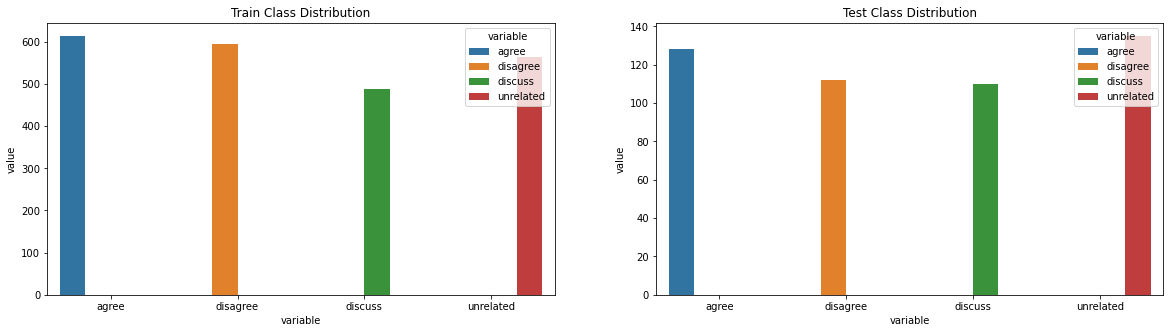

In [70]:
import seaborn as sns


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.barplot(
    data = pd.DataFrame.from_dict([label_disto(data.train['stance'])]).melt(), 
    x = "variable", 
    y="value", 
    hue="variable",  
    ax=axes[0]).set_title('Train Class Distribution')

sns.barplot(
    data = pd.DataFrame.from_dict([label_disto(data.test['stance'])]).melt(), 
    x = "variable", 
    y="value", 
    hue="variable",  
    ax=axes[1]).set_title('Test Class Distribution')


In [88]:
# create big poppa tensor of all labels
# target_list = []
# for t in data._target_df['stance']:
#     target_list.append(t)

# target_list = torch.tensor(target_list)

"""lets skip the weighted sampler for now
"""

'lets skip the weighted sampler for now\n'

In [89]:
class_count = [i for i in label_disto(data._target_df['stance']).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)

print(class_weights)

#class_weights_all = class_weights[target_list]

tensor([0.0016, 0.0017, 0.0020, 0.0018])


### Step 3 - Define model & training

In [107]:
# config
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

# hyperparameters
in_dim = 10001
hidden_dim = 100
out_dim = 4
epochs = 7 #90
batch = 10
lr = 0.01

In [108]:
# define neural net
class NN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(NN, self).__init__()
        # define layers
        self.l1 = nn.Linear(in_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_dim, out_dim)
    
    # applies layers with sample x
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

model = NN(in_dim, hidden_dim, out_dim).to(device)

criterion = nn.CrossEntropyLoss() # this also applies softmax for us
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [109]:
train_loader = DataLoader(dataset=data, batch_size=1, shuffle=True, num_workers=1)

In [120]:
"""
Test block to check if enumerate works correctly 
(data should return 2 values: input, label)
"""
for i, data in enumerate(train_loader):
    if i > 0:
        break
    print(data)
         

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.]]]], dtype=torch.float64)


In [114]:
"""
training loop
"""

running_loss = 0.
last_loss = 0.

for epoch in range(epochs):
    # enumerate to track the batch index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        inputs, labels = data

        # zero gradients each batch
        optimizer.zero_grad()

        # predict for batch
        outputs = model(inputs)

        # compute loss and gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # adjust weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.


ValueError: not enough values to unpack (expected 2, got 1)